## Group 103 Final Project

**Team Members**: Michael Bell, Xiaosong "Jack" Xu<br/>
Data Source: http://www.trumptwitterarchive.com/archive

### Table of Contents
* [Import Libraries](#imp)
* [Manual Classifications](#classify)
* [Clean Data](#clean)
* [Split](#split)
* [Train & Evaluate](#TE)

<a id='imp'></a>
### Import Libraries & Raw Data

In [1]:
import requests
import pandas as pd
import csv
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv(r'TrumpTweets.csv')
data.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,...Remember this. Throughout the ages some thi...,1/1/2019 1:05,28529.0,135209.0,False,1.079910e+18
1,Twitter for iPhone,The Democrats will probably submit a Bill bein...,1/1/2019 0:51,22897.0,99239.0,False,1.079900e+18
2,Twitter for iPhone,MEXICO IS PAYING FOR THE WALL through the many...,1/1/2019 0:40,23882.0,104440.0,False,1.079900e+18
3,Twitter for iPhone,HAPPY NEW YEAR! https://t.co/bHoPDPQ7G6,12/31/2018 23:53,32999.0,132907.0,False,1.079890e+18
4,Twitter for iPhone,Heads of countries are calling wanting to know...,12/31/2018 20:02,20519.0,74566.0,False,1.079830e+18


In [3]:
df = data[['text', 'created_at', 'retweet_count', 'favorite_count', 'id_str']] #eliminate columns not needed
df["class"] = ""
df.head()

C:\Users\mbell113538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,text,created_at,retweet_count,favorite_count,id_str,class
0,...Remember this. Throughout the ages some thi...,1/1/2019 1:05,28529.0,135209.0,1.079910e+18,
1,The Democrats will probably submit a Bill bein...,1/1/2019 0:51,22897.0,99239.0,1.079900e+18,
2,MEXICO IS PAYING FOR THE WALL through the many...,1/1/2019 0:40,23882.0,104440.0,1.079900e+18,
3,HAPPY NEW YEAR! https://t.co/bHoPDPQ7G6,12/31/2018 23:53,32999.0,132907.0,1.079890e+18,
4,Heads of countries are calling wanting to know...,12/31/2018 20:02,20519.0,74566.0,1.079830e+18,


<a id='classify'></a>
### Classify based on key words to create a working dataset for train/test

In [53]:
#classify based on key words to get a working dataset
df["class"][df['text'].str.contains("thank you")] = "positive"
df["class"][df['text'].str.contains("trump")] = "positive"
#df["class"][df['text'].str.contains("great")] = "positive"

df["class"][df['text'].str.contains("horrible")] = "negative"
df["class"][df['text'].str.contains("worst")] = "negative"
df["class"][df['text'].str.contains("fake")] = "negative"
df["class"][df['text'].str.contains("democrats")] = "negative"
df.head()

C:\Users\mbell113538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mbell113538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mbell113538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

,text,created_at,retweet_count,favorite_count,id_str,class
4,heads countries calling wanting know senator s...,12/31/2018 20:02,20519.0,74566.0,1.079830e+18,positive
9,person america could say im bringing great tro...,12/31/2018 14:38,25252.0,111582.0,1.079750e+18,negative
19,absolutely nothing russian collusion kimberley...,12/30/2018 3:01,30777.0,118155.0,1.079210e+18,negative
20,2018 called year worker steve moore coauthor t...,12/29/2018 21:06,25797.0,109238.0,1.079120e+18,positive
40,democrats obstruction desperately needed wall ...,12/27/2018 19:41,20172.0,84780.0,1.078380e+18,negative


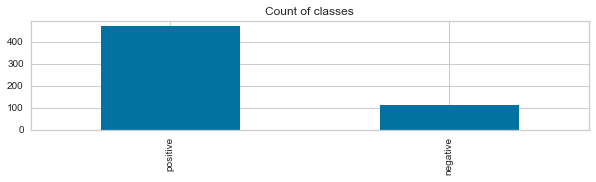

In [54]:
plt.figure(figsize=(10,2))
plt.title("Count of classes")
df['class'].value_counts().plot(kind='bar');

In [55]:
#eliminate blank classes
df = df.loc[df['class'] != '']
df.shape

(582, 6)

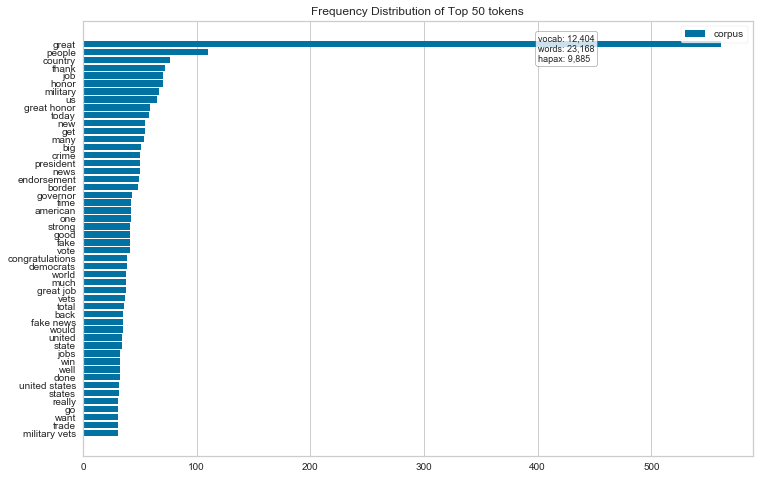

In [56]:
test = df.loc[df['class'] == '']

vectorizer = CountVectorizer(ngram_range=(1, 2))
docs       = vectorizer.fit_transform(df['text'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)

visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

In [57]:
df['text'][df['text'].str.contains("great")].head(10)

4     heads countries calling wanting know senator s...
9     person america could say im bringing great tro...
19    absolutely nothing russian collusion kimberley...
20    2018 called year worker steve moore coauthor t...
40    democrats obstruction desperately needed wall ...
45    hope everyone even fake news media great chris...
52    never lashed acting attorney general us man gr...
70    pleased announce talented deputy secretary def...
77    election said one greatest time based getting ...
78    crisis illegal activity southern border real s...
Name: text, dtype: object

<a id='clean'></a>
### Clean text and visualize uni-gram / bi-gram results

In [58]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('tco') #additional manual word removal
STOPWORDS.add('https') #additional manual word removal

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df['text'] = df['text'].apply(clean_text)

#Source: https://stackoverflow.com/questions/58603042/easier-way-to-clean-up-text

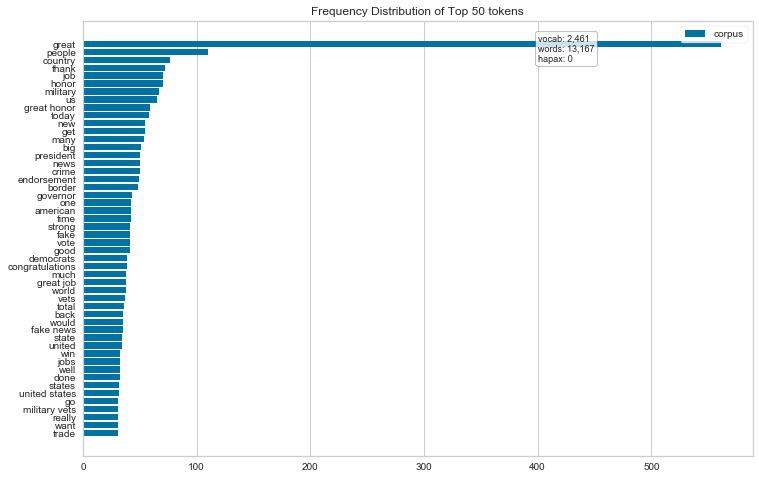

In [60]:
vectorizer = CountVectorizer(ngram_range=(1, 2),min_df=2)
docs       = vectorizer.fit_transform(df['text'],)
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features,n=50)


visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

In [61]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        ngram_range=(1, 2),
                        min_df=2,
                        stop_words='english')

features = tfidf.fit_transform(df.text)
labels = df.text
print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 582 tweets is represented by 2252 features (TF-IDF score of unigrams and bigrams)


<a id='split'></a>
### Split data into train/test set

In [70]:
X = df['text'] # Collection of documents
y = df['class'] # Target or the labels we want to predict 

X_train, X_test, y_train, y_test = train_test_split(df[['text']], df[['class']], 
                                                    test_size=0.8,
                                                    random_state = 42,
                                                    stratify = df[['class']]) #stratify=y.iloc[:,1]
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape:  ",X_test.shape)
print("y_test shape:  ",y_test.shape)

X_train shape:  (116, 1)
y_train shape:  (116, 1)
X_test shape:   (466, 1)
y_test shape:   (466, 1)


<a id='TE'></a>
### Train and Evaluate models

In [75]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    LinearSVC()
    #MultinomialNB(),
    #LogisticRegression(random_state=42),
]

# Cross-validation
CV = 2
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
print(cv_df)

C:\Users\mbell113538\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
C:\Users\mbell113538\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


               model_name  fold_idx  accuracy
0  RandomForestClassifier         0  0.008666
1  RandomForestClassifier         1  0.600000
2               LinearSVC         0  0.008666
3               LinearSVC         1  1.000000


In [78]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.504333,0.700979
RandomForestClassifier,0.304333,0.418137


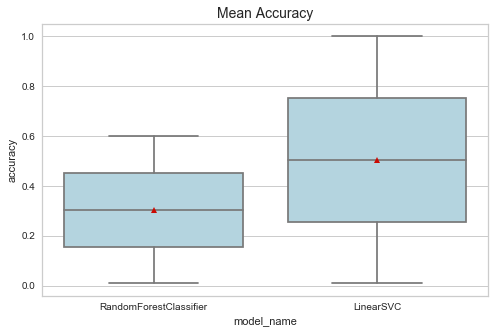

In [77]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("Mean Accuracy", size=14);

Baseline model estiablished. Next Steps: Further feature engineering and model refinement